# Hand localization model training with YOLOv5
In this notebook we will generate a model for the hand recognition and localization task using YOLOv5 and train it.
The procedure is divided into steps:
1) Manage dependencies and main YOLOv5 files
2) Download and extract dataset
3) Check on from some random samples that conversion is good
4) Last steps
5) Train the model

### 1) Download YOLO and import necessary dependencies

In [1]:
import os, shutil
import random
if not os.path.isdir('yolov5'):
    os.system('git clone https://github.com/ultralytics/yolov5')

# install and import yolov5 dependencies
!pip install -qr yolov5/requirements.txt
import torch, random
import numpy as np
from IPython.display import Image, clear_output

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

# import dependencies to extract dataset
import requests, tarfile, glob

# import & install dependencies needed to convert dataset label format to yolov5
!apt-get install libmagic-dev
!pip install python-magic
import magic, re, scipy.io

# import libs to verify conversion in step 4
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

Cloning into 'yolov5'...


Setup complete. Using torch 1.12.0+cu116 (Quadro RTX 5000)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libmagic-dev
--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1752, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1390, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/segment.py", line 245, in split_lines
    for segment in segments:
  File "/usr/local/lib/pyt

### 2) Download and extract dataset
We now check for the presence of the three datasets, if the program doesn't find them then it will procede to download them.
We also clone a support repository created to supply this notebook with all the annotations alredy converted in the yolov5 notation (converting the annotation in the notebook would be an unneccessary extra step),
and the HandsOverFace dataset alredy extracted and cleared from images used in the provided evaluation dataset.
We chose to upload HandsOverFace into a repository not for the fact that is easier, but because it was not possible for us to unzip it in the notebook.

In [2]:
# check if datasets have been downloaded: download it otherwise

# First we import the oxford dataset
oxford_path = "hand_dataset.tar.gz"
if not(os.path.exists(oxford_path)):
    response = requests.get("https://www.robots.ox.ac.uk/~vgg/data/hands/downloads/hand_dataset.tar.gz")
    open(oxford_path, "wb").write(response.content)

# Then the egohands dataset
egohands_path = 'egohands_data.zip'
if not(os.path.exists(egohands_path)):
  response = requests.get('http://vision.soic.indiana.edu/egohands_files/egohands_data.zip')
  open(egohands_path, 'wb').write(response.content)

# And finally we import the hands_over_face dataset, plus all the labels we previously converted
repo_path = 'dataset_CV'
if not(os.path.exists(repo_path)):
    !git clone https://github.com/afParadox/dataset_CV.git

Cloning into 'dataset_CV'...
remote: Enumerating objects: 19645, done.
remote: Counting objects: 100% (3800/3800), done.
remote: Compressing objects: 100% (3732/3732), done.
remote: Total 19645 (delta 4), reused 3794 (delta 2), pack-reused 15845
Receiving objects: 100% (19645/19645), 1.23 GiB | 20.27 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (10105/10105), done.


In the next cell we create the dataset directory, where we'll unzip all the files and reorganize them into training, validation and test.

In [3]:
if not(os.path.exists('dataset/')):
    !mkdir dataset dataset/images/ dataset/labels/ dataset/egohands
    !tar -xvzf hand_dataset.tar.gz -C dataset/
    !unzip egohands_data.zip -d dataset/egohands

hand_dataset/
hand_dataset/._.DS_Store
hand_dataset/.DS_Store
hand_dataset/evaluation_code/
hand_dataset/evaluation_code/._.DS_Store
hand_dataset/evaluation_code/.DS_Store
hand_dataset/evaluation_code/._evaluate_results.m
hand_dataset/evaluation_code/evaluate_results.m
hand_dataset/evaluation_code/globals.m
hand_dataset/evaluation_code/gt_diff_bigandall.mat
hand_dataset/evaluation_code/gt_test_big.mat
hand_dataset/evaluation_code/init.m
hand_dataset/evaluation_code/._README.txt
hand_dataset/evaluation_code/README.txt
hand_dataset/evaluation_code/._run.m
hand_dataset/evaluation_code/run.m
hand_dataset/evaluation_code/._test.m
hand_dataset/evaluation_code/test.m
hand_dataset/evaluation_code/VOC2007/
hand_dataset/evaluation_code/VOC2007/.DS_Store
hand_dataset/evaluation_code/VOC2007/VOCdevkit/
hand_dataset/evaluation_code/VOC2007/VOCdevkit/.DS_Store
hand_dataset/evaluation_code/VOC2007/VOCdevkit/results/
hand_dataset/evaluation_code/VOC2007/VOCdevkit/results/VOC2006/
hand_dataset/evaluati

Now we organize the three datasets that we downloaded into a single one, removing all non-necessary files, and renaming the files when necessary, as in the case of the egohands dataset.
The photos included in the evaluation dataset provided by the professor get removed from the dataset used in these cells.
In the case of the egohands dataset we also get rid of the whole folders where the photos from the evaluation dataset have been taken. From the total of 48 subfolders in the dataset, only 39 are been used for the training.

We set as final_path the directory dataset/images/ since all images of the datasets will be moved there.

In [4]:
final_path = 'dataset/images/'

Because of the problematic names of the photos of the EgoHands dataset we are forced to rename them all. For every folder we start naming the files from a multiple of 1000.
We are also careful to just move the folders that don't include an image that is used in the evaluation dataset provided by the professor.

In [5]:
# egohands
path = 'dataset/egohands/_LABELLED_SAMPLES/CARDS_COURTYARD_B_T/'
counter = 1000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/CARDS_COURTYARD_H_S/'
counter = 2000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/CARDS_COURTYARD_S_H/'
counter = 4000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/CARDS_COURTYARD_T_B/'
counter = 3000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/CARDS_LIVINGROOM_H_S/'
counter = 5000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/CARDS_LIVINGROOM_S_H/'
counter = 6000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/CARDS_LIVINGROOM_T_B/'
counter = 7000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/CARDS_OFFICE_S_B/'
counter = 8000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/CARDS_OFFICE_T_H/'
counter = 9000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/CHESS_COURTYARD_H_S/'
counter = 10000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/CHESS_COURTYARD_S_H/'
counter = 11000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/CHESS_COURTYARD_T_B/'
counter = 12000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/CHESS_LIVINGROOM_B_S/'
counter = 13000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/CHESS_LIVINGROOM_H_T/'
counter = 14000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/CHESS_LIVINGROOM_S_B/'
counter = 15000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/CHESS_LIVINGROOM_T_H/'
counter = 16000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/CHESS_OFFICE_H_T/'
counter = 17000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/CHESS_OFFICE_S_B/'
counter = 18000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/CHESS_OFFICE_T_H/'
counter = 19000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/JENGA_COURTYARD_H_B/'
counter = 20000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/JENGA_COURTYARD_S_T/'
counter = 21000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/JENGA_COURTYARD_T_S/'
counter = 22000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/JENGA_LIVINGROOM_B_H/'
counter = 23000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/JENGA_LIVINGROOM_S_T/'
counter = 24000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/JENGA_LIVINGROOM_T_S/'
counter = 25000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/JENGA_OFFICE_B_S/'
counter = 26000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/JENGA_OFFICE_H_T/'
counter = 27000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/JENGA_OFFICE_S_B/'
counter = 28000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/JENGA_OFFICE_T_H/'
counter = 29000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/PUZZLE_COURTYARD_H_T/'
counter = 30000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/PUZZLE_COURTYARD_S_B/'
counter = 31000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/PUZZLE_COURTYARD_T_H/'
counter = 32000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/PUZZLE_LIVINGROOM_B_T/'
counter = 33000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/PUZZLE_LIVINGROOM_H_S/'
counter = 34000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/PUZZLE_LIVINGROOM_S_H/'
counter = 35000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/PUZZLE_LIVINGROOM_T_B/'
counter = 36000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/PUZZLE_OFFICE_H_B/'
counter = 37000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/PUZZLE_OFFICE_S_T/'
counter = 38000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

path = 'dataset/egohands/_LABELLED_SAMPLES/PUZZLE_OFFICE_T_S/'
counter = 39000
for file in sorted(glob.glob(path + '*.jpg')):
  new_name = path + str(counter) + '.jpg'
  print(file + ' -> ' + new_name)
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

!rm -rf dataset/egohands/

dataset/egohands/_LABELLED_SAMPLES/CARDS_COURTYARD_B_T/frame_0011.jpg -> dataset/egohands/_LABELLED_SAMPLES/CARDS_COURTYARD_B_T/1000.jpg
dataset/egohands/_LABELLED_SAMPLES/CARDS_COURTYARD_B_T/frame_0036.jpg -> dataset/egohands/_LABELLED_SAMPLES/CARDS_COURTYARD_B_T/1001.jpg
dataset/egohands/_LABELLED_SAMPLES/CARDS_COURTYARD_B_T/frame_0099.jpg -> dataset/egohands/_LABELLED_SAMPLES/CARDS_COURTYARD_B_T/1002.jpg
dataset/egohands/_LABELLED_SAMPLES/CARDS_COURTYARD_B_T/frame_0113.jpg -> dataset/egohands/_LABELLED_SAMPLES/CARDS_COURTYARD_B_T/1003.jpg
dataset/egohands/_LABELLED_SAMPLES/CARDS_COURTYARD_B_T/frame_0176.jpg -> dataset/egohands/_LABELLED_SAMPLES/CARDS_COURTYARD_B_T/1004.jpg
dataset/egohands/_LABELLED_SAMPLES/CARDS_COURTYARD_B_T/frame_0183.jpg -> dataset/egohands/_LABELLED_SAMPLES/CARDS_COURTYARD_B_T/1005.jpg
dataset/egohands/_LABELLED_SAMPLES/CARDS_COURTYARD_B_T/frame_0184.jpg -> dataset/egohands/_LABELLED_SAMPLES/CARDS_COURTYARD_B_T/1006.jpg
dataset/egohands/_LABELLED_SAMPLES/CARDS_

In the case of the oxford dataset we don't have to change every image name, but only the ones in the test_data subdirectory, since their names conflict with other files in the dataset.
Also, we have to check each folder for the extra files that we don't need.

In [6]:
# oxford 
path = 'dataset/hand_dataset/training_dataset/training_data/images/'
for file in os.listdir(path):
  if file == '._.DS_Store' or file == '.DS_Store': continue
  os.rename(path + file, final_path + file)

path = 'dataset/hand_dataset/validation_dataset/validation_data/images/'
for file in os.listdir(path):
  if file == '._.DS_Store' or file == '.DS_Store': continue
  os.rename(path + file, final_path + file)

path = 'dataset/hand_dataset/test_dataset/test_data/images/'
counter = 40000
for file in sorted(glob.glob(path + '*.jpg')):
  if file == '._.DS_Store' or file == '.DS_Store': continue
  os.rename(file, final_path + str(counter) + '.jpg')
  counter += 1

!rm -rf dataset/hand_dataset

In the case of the HandsOverFace dataset we just import it from the support repository and move it into the images folder.

In [7]:
# hands over face
path = 'dataset_CV/hands_over_face/'
for file in os.listdir(path):
  os.rename(path + file, final_path + file)



As the last step of this organization we also move all the annotations from the photos into the dataset/labels/ directory,
to have a easier to understand structure of the data.

In [8]:
# Finally we move the labels we imported to the labels folder
final_path = 'dataset/labels/'
initial_path = 'dataset_CV/labels/'
for file in os.listdir(initial_path):
  os.rename(initial_path + file, final_path + file)

!rm -rf dataset_CV

The next cell serves the purpose of checking that we moved all the data correctly.
First we check that we have the same number of images and annotation files by printing the number of files in each one,
and if an annotation file is missing then we print the name of its respective image.

In [9]:
print(len(os.listdir('dataset/images/')))
print(len(os.listdir('dataset/labels/')))

path_1 = 'dataset/images/'
path_2 = 'dataset/labels/'

for file in os.listdir(path_1):
    txt_name = file[:-4] + '.txt'
    if txt_name not in os.listdir(path_2):
        print(txt_name + ' missing')


9816
9816


Now we want to create the validation and test set. We just take 1000 random samples for validation and 800 for test.

In [10]:
!mkdir dataset/validation/ dataset/validation/images/ dataset/validation/labels/
!mkdir dataset/test/ dataset/test/images dataset/test/labels

random.seed(10000)

images_path = 'dataset/images/'
labels_path = 'dataset/labels/'
validation_images = 'dataset/validation/images/'
validation_labels = 'dataset/validation/labels/'
test_images = 'dataset/test/images/'
test_labels = 'dataset/test/labels/'

# Here we populate the validation set
for i in range(1000):
  list = sorted(os.listdir(images_path))
  n = random.randint(0, len(list) - 1)
  print(list[n][:-4] + ' -> validation')
  os.rename(images_path + list[n], validation_images + list[n])
  os.rename(labels_path + list[n][:-4] + '.txt', validation_labels + list[n][:-4] + '.txt')

# Here we populate the test set


for i in range(800):
  list = sorted(os.listdir(images_path))
  n = random.randint(0, len(list) - 1)
  print(list[n][:-4] + ' -> test')
  os.rename(images_path + list[n], test_images + list[n])
  os.rename(labels_path + list[n][:-4] + '.txt', test_labels + list[n][:-4] + '.txt')
  
print(len(os.listdir(validation_images)))
print(len(os.listdir(validation_labels)))
print(len(os.listdir(test_images)))
print(len(os.listdir(test_labels)))

VOC2010_686 -> validation
8098 -> validation
14052 -> validation
251 -> validation
12089 -> validation
10038 -> validation
40683 -> validation
VOC2007_751 -> validation
Buffy_404 -> validation
33061 -> validation
23079 -> validation
VOC2010_58 -> validation
Movie_4weds_132 -> validation
10087 -> validation
Buffy_12 -> validation
12000 -> validation
VOC2010_65 -> validation
40152 -> validation
120 -> validation
Buffy_446 -> validation
VOC2010_749 -> validation
VOC2010_739 -> validation
40766 -> validation
VOC2010_1082 -> validation
VOC2010_1203 -> validation
31059 -> validation
25069 -> validation
21077 -> validation
Buffy_314 -> validation
11051 -> validation
Movie_forrest_23 -> validation
3047 -> validation
18035 -> validation
Inria_75 -> validation
VOC2007_197 -> validation
Movie_forrest_103 -> validation
4059 -> validation
Buffy_478 -> validation
Movie_4weds_151 -> validation
VOC2010_1236 -> validation
VOC2007_679 -> validation
VOC2010_811 -> validation
Buffy_329 -> validation
VOC20

### 3) Check conversions
Now to check if the conversion result is correct by visualizing random samples for each subset of the dataset and drawing the converted bounding box(es) onto it.<br>

24059.jpg
VOC2010_502.jpg
40209.jpg


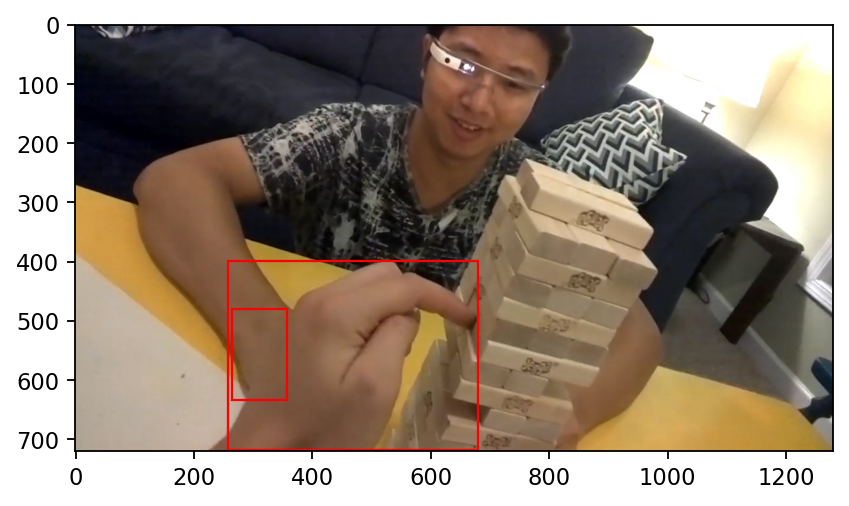

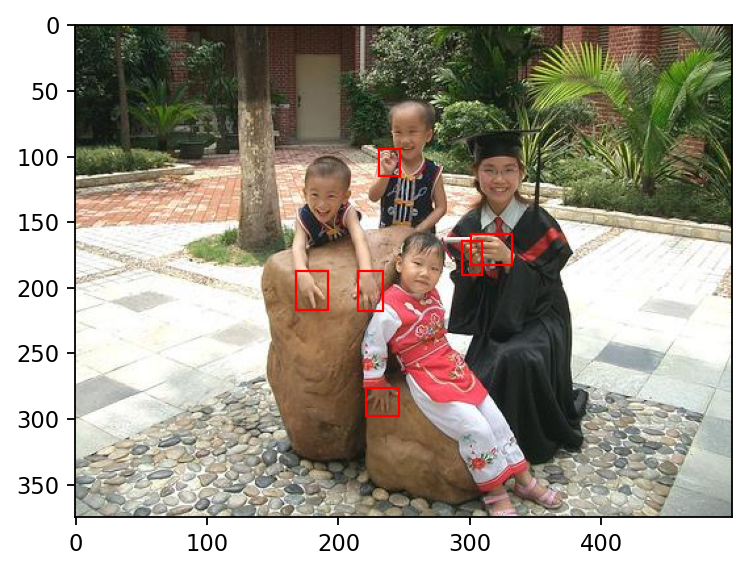

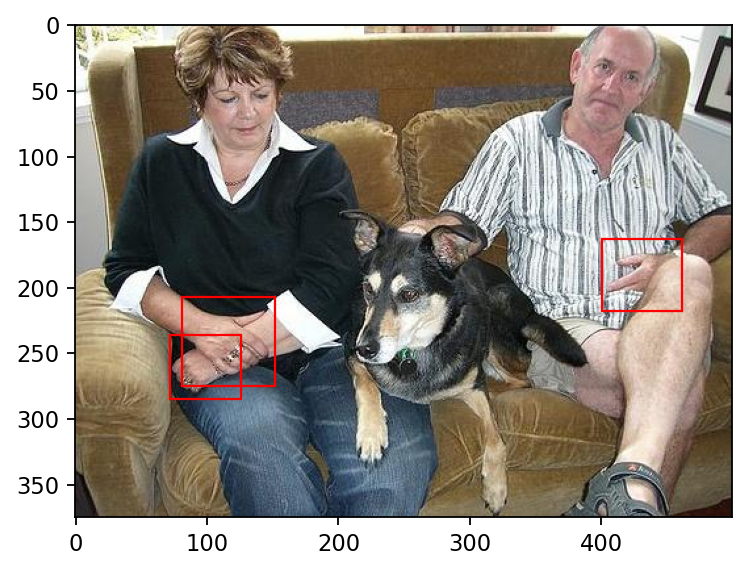

In [14]:
datasets_extr = ["dataset/","dataset/test/", "dataset/validation/"]

for dir_path in datasets_extr:
    # randomly select an image
    rnd_img = random.choice(os.listdir(dir_path + "images/"))
    print(rnd_img)

    # open the image
    img = Image.open(dir_path + "images/" + rnd_img)

    # create figure and axes
    fig, ax = plt.subplots(dpi=163)

    # display the image
    ax.imshow(img)

    #covert line string into ndarray
    bbox_yolo_coords = []
    with open(dir_path + "labels/" + rnd_img[:len(rnd_img)-4] + ".txt") as txt:

        lines = txt.read().splitlines()
        for line in lines:
            bbox_yolo_coords.append(np.fromstring(line[1:], dtype=float, sep=' ', count=4))

    # de-normalize coordinates and draw bbox onto img
    for box in bbox_yolo_coords:
        box[0] *= float(img.width)
        box[2] *= float(img.width)
        box[1] *= float(img.height)
        box[3] *= float(img.height)
        ax.add_patch(patches.Rectangle((box[0]-box[2]/2., box[1]-box[3]/2.), width=box[2], height=box[3], linewidth=1, edgecolor='r', facecolor='none'))


### 4) Last steps before training
Now we need to setup last things to train the yolo model. We will follow the following steps:
- Copy images and labels into a directory system suitable to yolov5

In [15]:
dirs = ["./images/", "./labels/", "./images/train/", "./labels/train/", "./images/val/", "./labels/val/", "./images/test/", "./labels/test/"]
for dir_ in dirs:
    if not os.path.exists(dir_):
        os.mkdir(dir_)

# move dataset into directories "images" and "labels" which are located in same position as the notebook
subsets = ["train/", "val/", "test/"]
for i in range(3):
    for img_name in os.listdir(datasets_extr[i] + "images/"):
        old_img_path = datasets_extr[i] + "images/" + img_name
        old_lbl_path = datasets_extr[i] + "labels/" + img_name[:len(img_name)-3] + "txt"
        new_img_path = dirs[0] + subsets[i] + img_name
        new_lbl_path = dirs[1] + subsets[i] + img_name[:len(img_name)-3] + "txt"

        # copy img if it's not already there
        if not os.path.exists(new_img_path):
            shutil.copyfile(old_img_path, new_img_path)
        if not os.path.exists(new_lbl_path):
            shutil.copyfile(old_lbl_path, new_lbl_path)

- Create dataset location _yaml_ file (In our case move the premade one into the right directory)

In [2]:
# move data.yaml
new_data_yaml = "./yolov5/data/hand_data.yaml"
if os.path.exists(new_data_yaml):
    os.remove(new_data_yaml)
shutil.copyfile("./hand_data.yaml", new_data_yaml)


print("------------------ hand_data.yaml ---------------------")
with open(new_data_yaml) as f:
    lines = f.read().splitlines()
    for line in lines:
        print("\t" + line)
print("-------------------------------------------------------")

------------------ hand_data.yaml ---------------------
	train: ../images/train/ 
	val:  ../images/val/
	test: ../images/test/
	
	# number of classes
	nc: 1
	
	# class names
	names: ["hand"]
-------------------------------------------------------


- Setup hyperparameters file, which will contain all usual parameters used when training a neural network (Same as before, we will move the premade one into the right directory)<br>
  We are just going to use the default one

In [17]:
hyperparams_yaml = "./yolov5/data/hyps/hyp.scratch-med.yaml"
print("-------------------------------------------------- hyp.scratch-med.yaml -----------------------------------------------------")
with open(hyperparams_yaml) as f:
    lines = f.read().splitlines()
    for line in lines:
        print("\t" + line)
print("-----------------------------------------------------------------------------------------------------------------------------")

-------------------------------------------------- hyp.scratch-med.yaml -----------------------------------------------------
	# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
	# Hyperparameters for medium-augmentation COCO training from scratch
	# python train.py --batch 32 --cfg yolov5m6.yaml --weights '' --data coco.yaml --img 1280 --epochs 300
	# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials
	
	lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
	lrf: 0.1  # final OneCycleLR learning rate (lr0 * lrf)
	momentum: 0.937  # SGD momentum/Adam beta1
	weight_decay: 0.0005  # optimizer weight decay 5e-4
	warmup_epochs: 3.0  # warmup epochs (fractions ok)
	warmup_momentum: 0.8  # warmup initial momentum
	warmup_bias_lr: 0.1  # warmup initial bias lr
	box: 0.05  # box loss gain
	cls: 0.3  # cls loss gain
	cls_pw: 1.0  # cls BCELoss positive_weight
	obj: 0.7  # obj loss gain (scale with pixels)
	obj_pw: 1.0  # obj BCELoss positive_weight
	iou_t: 0.2

- A custom network architecture can also be specified by specifing with _-cfg_ argument the custom network architecture file.<br>
  Below there is and example taken from a default yolo network architecture

In [18]:
net_architecture_yaml = "./yolov5/models/yolov5l.yaml"
print("------------------------------------------------------ yolov5m.yaml --------------------------------------------------------")
with open(net_architecture_yaml) as f:
    lines = f.read().splitlines()
    for line in lines:
        print("\t" + line)
print("-----------------------------------------------------------------------------------------------------------------------------")

------------------------------------------------------ yolov5m.yaml --------------------------------------------------------
	# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
	
	# Parameters
	nc: 80  # number of classes
	depth_multiple: 1.0  # model depth multiple
	width_multiple: 1.0  # layer channel multiple
	anchors:
	  - [10,13, 16,30, 33,23]  # P3/8
	  - [30,61, 62,45, 59,119]  # P4/16
	  - [116,90, 156,198, 373,326]  # P5/32
	
	# YOLOv5 v6.0 backbone
	backbone:
	  # [from, number, module, args]
	  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
	   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
	   [-1, 3, C3, [128]],
	   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
	   [-1, 6, C3, [256]],
	   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
	   [-1, 9, C3, [512]],
	   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
	   [-1, 3, C3, [1024]],
	   [-1, 1, SPPF, [1024, 5]],  # 9
	  ]
	
	# YOLOv5 v6.0 head
	head:
	  [[-1, 1, Conv, [512, 1, 1]],
	   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
	   [[-1, 6], 1, Concat, [1]],  # cat b

### 5) Training the yolo model

In [3]:
# 313 could be a good batch size (1,13,313,4069)
#!cd yolov5
!python yolov5/train.py --img 512 --cfg yolov5l.yaml --hyp hyp.scratch-med.yaml --batch 13 --epochs 120 --data hand_data.yaml --weights ' ' --workers 8 --name yolo_hand_localization

train: weights= , cfg=yolov5l.yaml, data=hand_data.yaml, hyp=hyp.scratch-med.yaml, epochs=120, batch_size=13, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=yolo_hand_localization, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-321-g2e1291f Python-3.9.13 torch-1.12.0+cu116 CUDA:0 (Quadro RTX 5000, 16125MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.3, cls_pw=1.0, obj=0.7, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=

Now to download the results: first create a zip file, then download it

In [4]:
!zip -r ./training_result_runs.zip ./yolov5/runs

  adding: yolov5/runs/ (stored 0%)
  adding: yolov5/runs/train/ (stored 0%)
  adding: yolov5/runs/train/yolo_hand_localization/ (stored 0%)
  adding: yolov5/runs/train/yolo_hand_localization/val_batch0_pred.jpg (deflated 12%)
  adding: yolov5/runs/train/yolo_hand_localization/F1_curve.png (deflated 18%)
  adding: yolov5/runs/train/yolo_hand_localization/results.png (deflated 14%)
  adding: yolov5/runs/train/yolo_hand_localization/R_curve.png (deflated 19%)
  adding: yolov5/runs/train/yolo_hand_localization/val_batch1_labels.jpg (deflated 15%)
  adding: yolov5/runs/train/yolo_hand_localization/events.out.tfevents.1658839714.ps7h1vyq2.92.0 (deflated 55%)
  adding: yolov5/runs/train/yolo_hand_localization/opt.yaml (deflated 46%)
  adding: yolov5/runs/train/yolo_hand_localization/confusion_matrix.png (deflated 41%)
  adding: yolov5/runs/train/yolo_hand_localization/train_batch1.jpg (deflated 7%)
  adding: yolov5/runs/train/yolo_hand_localization/labels.jpg (deflated 28%)
  adding: yolov5/r